# Decision Tree Classifier

## Theoretical Foundation

Decision trees are supervised learning algorithms used for classification and regression tasks. They partition the feature space into regions by recursively splitting on feature values, creating a tree-like structure of decisions.

### Information Theory Basis

The core principle behind decision tree construction is **information gain**, derived from Shannon's entropy. For a dataset $S$ with $K$ classes, the **entropy** is defined as:

$$H(S) = -\sum_{k=1}^{K} p_k \log_2(p_k)$$

where $p_k$ is the proportion of samples belonging to class $k$.

### Information Gain

When we split dataset $S$ on attribute $A$ with possible values $\{v_1, v_2, \ldots, v_n\}$, the **information gain** is:

$$IG(S, A) = H(S) - \sum_{v \in \text{Values}(A)} \frac{|S_v|}{|S|} H(S_v)$$

where $S_v$ is the subset of $S$ for which attribute $A$ has value $v$.

### Gini Impurity

An alternative splitting criterion is the **Gini impurity**:

$$G(S) = 1 - \sum_{k=1}^{K} p_k^2$$

Gini impurity measures the probability of incorrectly classifying a randomly chosen element if it were labeled according to the class distribution in $S$.

### Splitting Criterion for Continuous Features

For a continuous feature $x_j$, the tree finds the optimal threshold $\theta$ that maximizes information gain:

$$\theta^* = \arg\max_{\theta} IG(S, x_j \leq \theta)$$

This creates a binary split: samples with $x_j \leq \theta$ go to the left child, others to the right.

### Classification Rule

For a leaf node $L$ containing samples from multiple classes, the predicted class is:

$$\hat{y} = \arg\max_{k} |\{(x_i, y_i) \in L : y_i = k\}|$$

i.e., the majority class in that leaf.

## Implementation

We will implement a decision tree classifier from scratch using numpy, then demonstrate its performance on a synthetic dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
class DecisionTreeNode:
    """Node in a decision tree."""
    
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        # For internal nodes
        self.feature_index = feature_index  # Index of feature to split on
        self.threshold = threshold          # Threshold value for split
        self.left = left                    # Left subtree (feature <= threshold)
        self.right = right                  # Right subtree (feature > threshold)
        
        # For leaf nodes
        self.value = value                  # Predicted class


class DecisionTreeClassifier:
    """Decision Tree Classifier using Gini impurity."""
    
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
    
    def fit(self, X, y):
        """Build the decision tree."""
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.root = self._grow_tree(X, y, depth=0)
        return self
    
    def _gini(self, y):
        """Calculate Gini impurity."""
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def _information_gain(self, y, y_left, y_right):
        """Calculate information gain from a split."""
        n = len(y)
        n_left, n_right = len(y_left), len(y_right)
        
        if n_left == 0 or n_right == 0:
            return 0
        
        parent_gini = self._gini(y)
        child_gini = (n_left / n) * self._gini(y_left) + (n_right / n) * self._gini(y_right)
        
        return parent_gini - child_gini
    
    def _best_split(self, X, y):
        """Find the best split for a node."""
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        for feature_idx in range(self.n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                gain = self._information_gain(y, y[left_mask], y[right_mask])
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _grow_tree(self, X, y, depth):
        """Recursively grow the decision tree."""
        n_samples = len(y)
        n_labels = len(np.unique(y))
        
        # Stopping criteria
        if (depth >= self.max_depth or 
            n_labels == 1 or 
            n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)
        
        # Find best split
        best_feature, best_threshold = self._best_split(X, y)
        
        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)
        
        # Create child splits
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        left_child = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._grow_tree(X[right_mask], y[right_mask], depth + 1)
        
        return DecisionTreeNode(
            feature_index=best_feature,
            threshold=best_threshold,
            left=left_child,
            right=right_child
        )
    
    def _most_common_label(self, y):
        """Return the most common class label."""
        counter = Counter(y)
        return counter.most_common(1)[0][0]
    
    def predict(self, X):
        """Predict class labels for samples."""
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        """Traverse the tree to make a prediction."""
        if node.value is not None:
            return node.value
        
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

## Generate Synthetic Dataset

We create a two-dimensional dataset with three classes arranged in distinct clusters.

In [3]:
def generate_data(n_samples=300):
    """Generate synthetic classification data with 3 classes."""
    n_per_class = n_samples // 3
    
    # Class 0: Cluster centered at (1, 1)
    X0 = np.random.randn(n_per_class, 2) * 0.5 + np.array([1, 1])
    y0 = np.zeros(n_per_class, dtype=int)
    
    # Class 1: Cluster centered at (4, 1)
    X1 = np.random.randn(n_per_class, 2) * 0.5 + np.array([4, 1])
    y1 = np.ones(n_per_class, dtype=int)
    
    # Class 2: Cluster centered at (2.5, 4)
    X2 = np.random.randn(n_per_class, 2) * 0.5 + np.array([2.5, 4])
    y2 = np.full(n_per_class, 2, dtype=int)
    
    X = np.vstack([X0, X1, X2])
    y = np.concatenate([y0, y1, y2])
    
    # Shuffle the data
    shuffle_idx = np.random.permutation(len(y))
    return X[shuffle_idx], y[shuffle_idx]

# Generate dataset
X, y = generate_data(300)

# Split into train and test sets
split_idx = int(0.8 * len(y))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 240
Test samples: 60


## Train the Decision Tree

In [4]:
# Train the classifier
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=5)
clf.fit(X_train, y_train)

# Make predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Calculate accuracy
train_accuracy = np.mean(y_pred_train == y_train)
test_accuracy = np.mean(y_pred_test == y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Test Accuracy: 0.9833


## Visualize Decision Boundaries

We visualize the decision boundaries created by the tree along with the training data points.

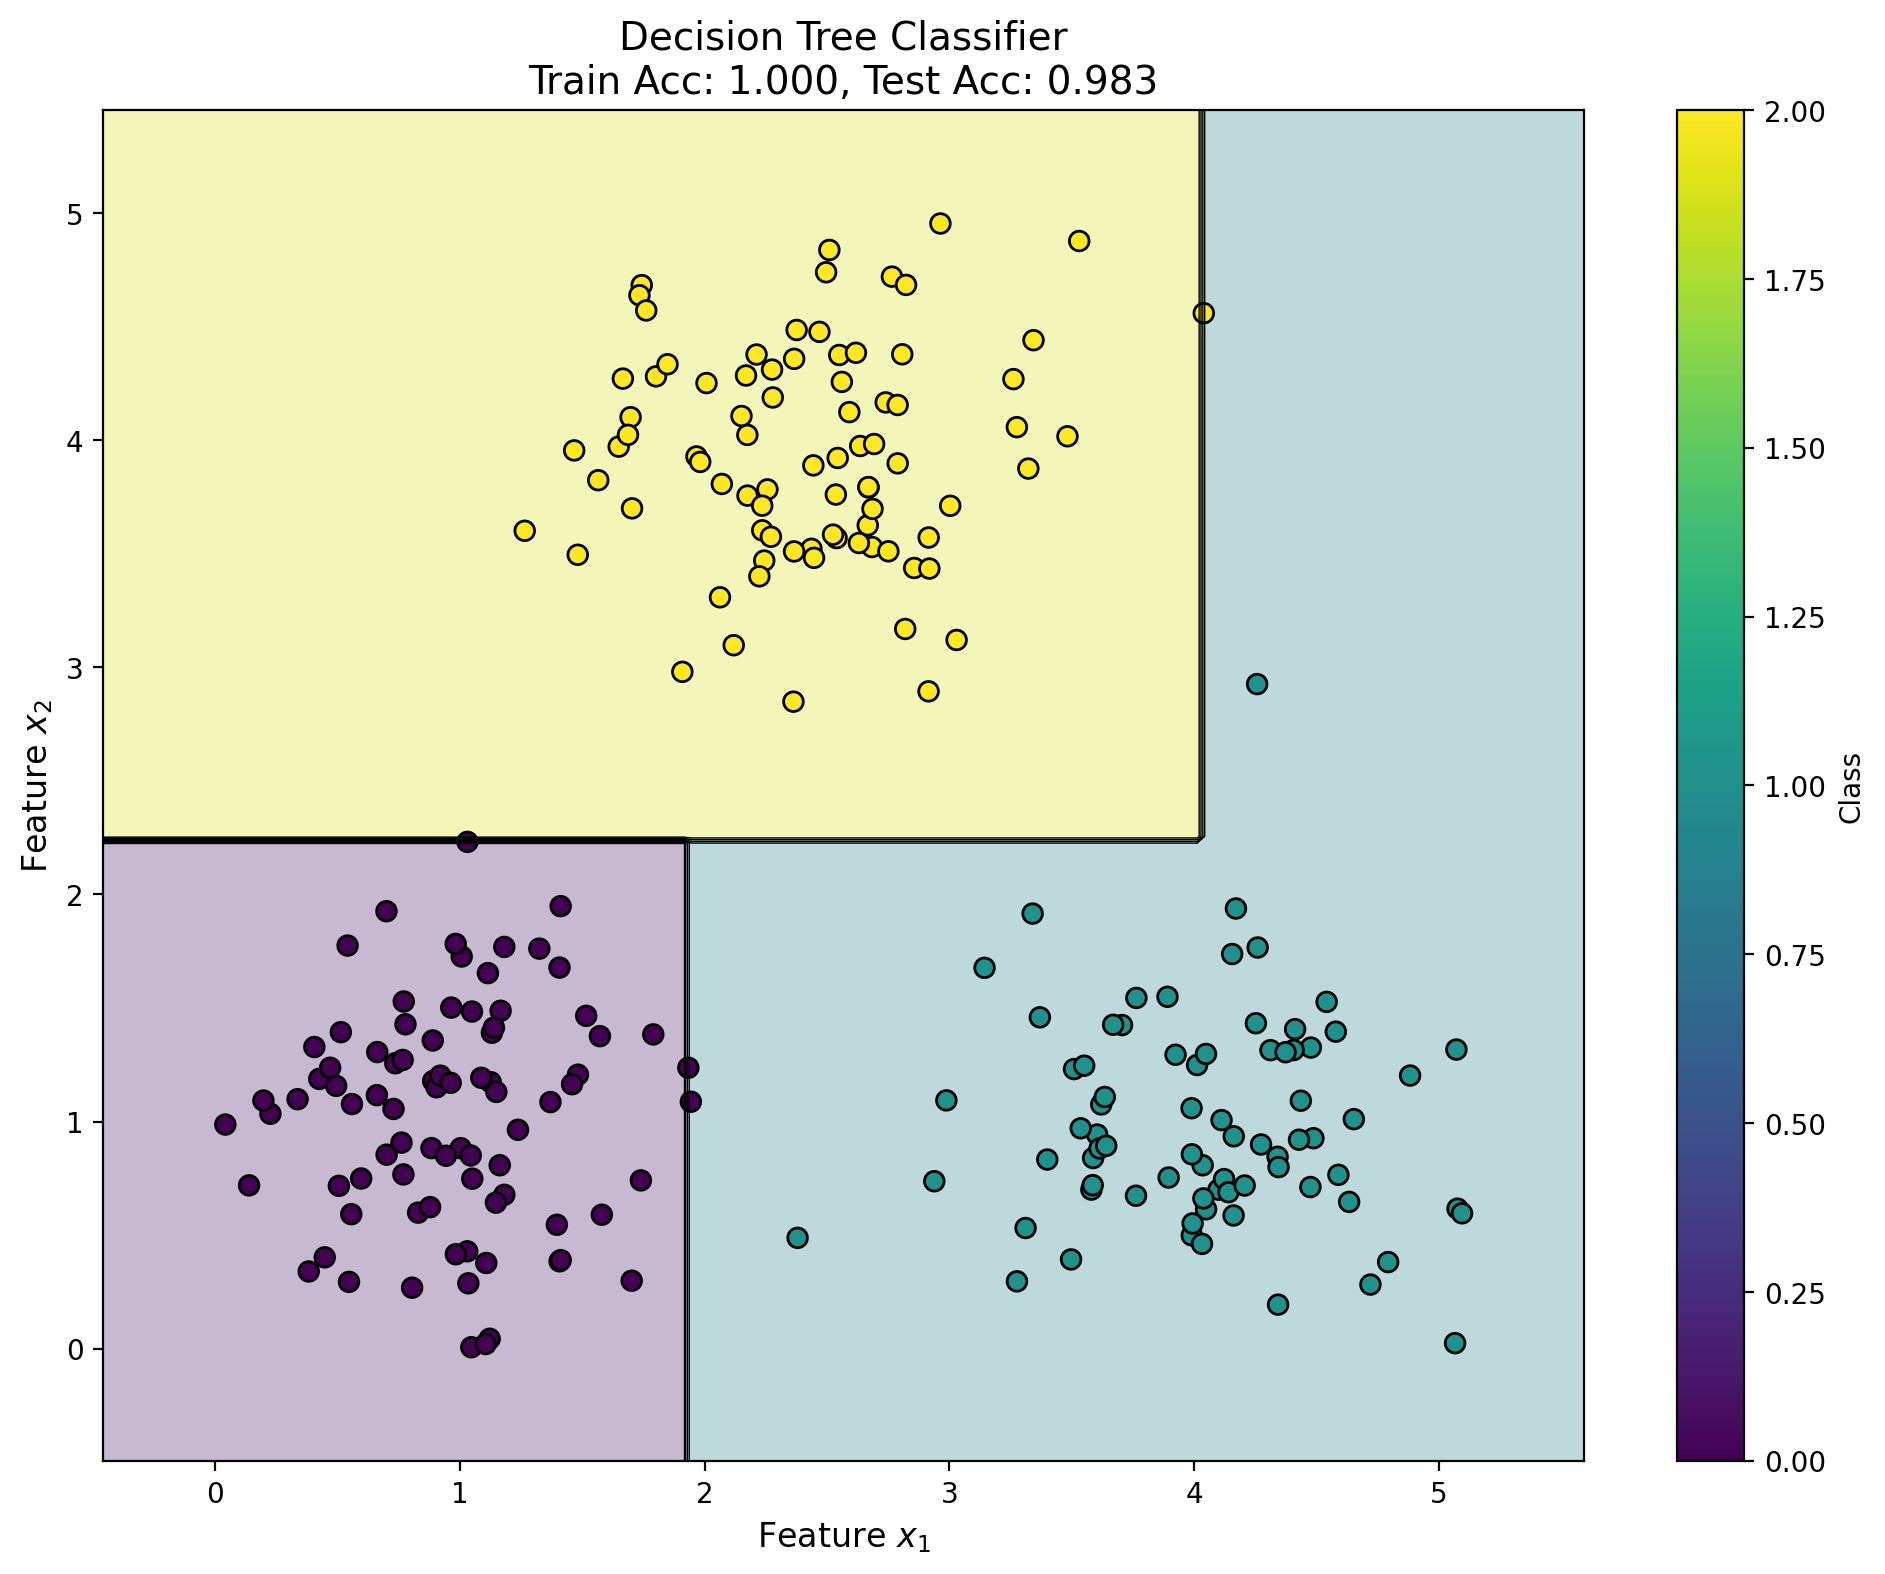

Plot saved to plot.png


In [5]:
def plot_decision_boundary(clf, X, y, title):
    """Plot decision boundaries and data points."""
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Get predictions for mesh grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot decision regions
    contour = ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    
    # Plot decision boundaries
    ax.contour(xx, yy, Z, colors='k', linewidths=0.5)
    
    # Plot data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', 
                         edgecolors='black', s=50)
    
    ax.set_xlabel('Feature $x_1$', fontsize=12)
    ax.set_ylabel('Feature $x_2$', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Class', fontsize=10)
    
    plt.tight_layout()
    return fig

# Create visualization
fig = plot_decision_boundary(
    clf, X_train, y_train,
    f'Decision Tree Classifier\nTrain Acc: {train_accuracy:.3f}, Test Acc: {test_accuracy:.3f}'
)

# Save plot
plt.savefig('decision_tree_classifier_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to plot.png")

## Analysis of Results

The decision tree classifier successfully partitions the feature space into regions corresponding to each class. The decision boundaries are axis-aligned (parallel to feature axes), which is characteristic of decision trees using single-feature splits.

### Key Observations

1. **Interpretability**: Each decision boundary corresponds to a threshold on a single feature, making the model highly interpretable.

2. **Non-linear Boundaries**: Despite using only linear splits, the combination of multiple splits creates non-linear decision boundaries.

3. **Gini Impurity**: The algorithm minimizes Gini impurity at each split:
   $$G(S) = 1 - \sum_{k=1}^{K} p_k^2$$

4. **Overfitting Control**: The `max_depth` and `min_samples_split` hyperparameters prevent the tree from growing too deep and overfitting to noise.

### Computational Complexity

- **Training**: $O(n \cdot m \cdot \log(n))$ where $n$ is the number of samples and $m$ is the number of features
- **Prediction**: $O(\log(n))$ for balanced trees, $O(n)$ worst case